In [1]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable
import time
import collections
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor, tensor
import pandas as pd
import openml


from optuna_kfoldCV import evaluate_dataset_with_model, run_all_openML_with_model
from classification_param_specs import evaluate_LogisticRegression, evaluate_XGBoostClassifier

np.set_printoptions(precision=3, threshold=5) # Print options

# OpenML code

In [ ]:
# # Fetch the collection with ID 99 https://www.openml.org/search?type=study&study_type=task&id=99&sort=runs_included
# collection = openml.study.get_suite(99)
# dataset_ids = collection.data
# metadata_list = []

# # Fetch and process each dataset
# for i, dataset_id in enumerate(dataset_ids):
#     dataset = openml.datasets.get_dataset(dataset_id)
#     X, y, categorical_indicator, attribute_names = dataset.get_data(
#         target=dataset.default_target_attribute
#     )

#     #count missing values in X
#     missing_values_count = X.isnull().sum().sum()
#     print(f"Missing values in X: {missing_values_count}")

#     X = np.array(X)
#     y = np.array(y)[..., None]
#     print(X.shape)
#     print(y.shape)
    
#     # Determine if the dataset has categorical features
#     has_categorical = any(categorical_indicator)
    
#     # Extract the required metadata
#     metadata = {
#         'dataset_id': dataset.id,
#         'name': dataset.name,
#         'n_obs': int(dataset.qualities['NumberOfInstances']),
#         'n_features': int(dataset.qualities['NumberOfFeatures']),
#         '%_unique_y': len(np.unique(y))/len(y),
#         'n_unique_y': len(np.unique(y)),
#         'has_categorical': has_categorical,
#         'n_missing_values': missing_values_count,
#     }
    
#     metadata_list.append(metadata)
#     print(f" {i+1}/{len(dataset_ids)} Processed dataset {dataset.id}: {dataset.name}")

# # Create a DataFrame from the metadata list
# df_metadata = pd.DataFrame(metadata_list).sort_values('%_unique_y', ascending=False).set_index("dataset_id").sort_index()
# df_metadata.sort_values('%_unique_y', ascending=True)

# # Display the metadata DataFrame
# df_metadata

In [ ]:
# pd.set_option('display.max_rows', 72)
# df_metadata.head(72).sort_values("n_obs")

In [ ]:
# df_metadata.index

In [56]:
from optuna_kfoldCV import np_load_openml_dataset, openML_cls_ids
import numpy as np


for idx, id in enumerate(openML_cls_ids):
    X,y = np_load_openml_dataset(id, "classification")
    print("idx", idx, "id", id, "X", X.shape, "y", y.shape, np.isnan(X).sum(), np.isnan(y).sum())

# for id in df_metadata.index:
#     X,y = np_load_openml_dataset(id, "classification")
#     print("id", id, "X", X.shape, "y", y.shape, np.isnan(X).sum(), np.isnan(y).sum())

## TODO TODO TODO NEXT: investigate nans, and "Mean of empty slice". also look at less than 200 classes and check performance on reg

idx 0 id 3 X (3196, 74) y (3196, 1) 0 0
idx 1 id 6 X (5000, 16) y (5000, 26) 0 0
idx 2 id 11 X (625, 4) y (625, 3) 0 0
idx 3 id 14 X (2000, 76) y (2000, 10) 0 0
idx 4 id 15 X (699, 9) y (699, 1) 0 0
idx 5 id 16 X (2000, 64) y (2000, 10) 0 0
idx 6 id 18 X (2000, 6) y (2000, 10) 0 0
idx 7 id 22 X (2000, 47) y (2000, 10) 0 0
idx 8 id 23 X (1473, 24) y (1473, 3) 0 0
idx 9 id 28 X (5000, 64) y (5000, 10) 0 0
idx 10 id 29 X (690, 47) y (690, 1) 0 0
idx 11 id 31 X (1000, 63) y (1000, 1) 0 0
idx 12 id 32 X (5000, 16) y (5000, 10) 0 0
idx 13 id 37 X (768, 8) y (768, 1) 0 0
idx 14 id 38 X (3772, 53) y (3772, 1) 0 0
idx 15 id 44 X (4601, 57) y (4601, 1) 0 0
idx 16 id 50 X (958, 27) y (958, 1) 0 0
idx 17 id 54 X (846, 18) y (846, 4) 0 0
idx 18 id 151 X (5000, 14) y (5000, 1) 0 0
idx 19 id 182 X (5000, 36) y (5000, 6) 0 0
idx 20 id 188 X (736, 91) y (736, 5) 0 0
idx 21 id 307 X (990, 27) y (990, 11) 0 0
idx 22 id 458 X (841, 70) y (841, 4) 0 0
idx 23 id 469 X (797, 21) y (797, 6) 0 0
idx 24 id 1049

# Run experiments (just for testing)

In [ ]:
# !python classification_param_specs.py \
#     --models End2End \
#     --dataset_indices 0 2 \
#     --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLClassification/ \
#     --n_optuna_trials 2 \
#     --device cuda \
#     --k_folds 5 \
#     --cv_seed 42

In [ ]:
# !python classification_param_specs.py \
#     --models LogisticRegression \
#     --dataset_indices 0 2 \
#     --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLClassification/ \
#     --n_optuna_trials 10 \
#     --device cuda \
#     --k_folds 2 \
#     --cv_seed 42

In [ ]:
# !python classification_param_specs.py \
#     --models XGBoostClassifier \
#     --dataset_indices 0 2 \
#     --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLClassification/ \
#     --n_optuna_trials 2 \
#     --device cuda \
#     --k_folds 2 \
#     --cv_seed 42

In [ ]:
# !python classification_param_specs.py \
#     --models RFNN \
#     --dataset_indices 0 2 \
#     --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLClassification/ \
#     --n_optuna_trials 2 \
#     --device cuda \
#     --k_folds 5 \
#     --cv_seed 42

In [ ]:
# !python classification_param_specs.py \
#     --models RFRBoost \
#     --dataset_indices 0 2 \
#     --save_dir /home/nikita/Code/random-feature-boosting/save/OpenMLClassification/ \
#     --n_optuna_trials 2 \
#     --device cuda \
#     --k_folds 5 \
#     --cv_seed 42

# join json results

In [2]:
from pydantic.v1.utils import deep_update
import json
import os
import numpy as np
import pandas as pd

from optuna_kfoldCV import openML_cls_ids


def read_json(path):
    with open(path, "r") as f:
        return json.load(f)
    


def custom_deep_update(original, update):
    for key, value in update.items():
        if isinstance(value, dict) and key in original:
            custom_deep_update(original[key], value)
        else:
            original[key] = value



def get_joined_results_json(
        models = ["End2End", "Ridge", "XGBoostRegressor",
                  "GradientRFRBoost", "GradientRFRBoostID", 
                  "GreedyRFRBoostDense", "GreedyRFRBoostDiag", "GreedyRFRBoostScalar",
                  "RandomFeatureNetwork"],
        datasets = openML_cls_ids,
        save_dir = "/home/nikita/Code/random-feature-boosting/save/OpenMLClassification/",
        classification_or_regression = "classification",
        ):
    results_json = {}
    for model in models:
        for dataset in datasets:
            path = os.path.join(save_dir, f"{classification_or_regression}_{dataset}_{model}.json")
            res = read_json(path)
            if results_json == {}:
                results_json = res
            else:
                custom_deep_update(results_json, res)
    return results_json



def join_jsons_into_array(
        results_json,
        ):
    results = []
    for dataset, dataset_results in results_json.items():
        res = []
        for model_name, model_results in dataset_results.items():
            model_res = np.stack([model_results["score_train"], model_results["score_test"], model_results["t_fit"], model_results["t_inference"]])
            res.append(model_res)
        results.append(res)
    return np.stack(results) # (n_datasets, n_models, 4, n_folds)


def results_to_df(
        models = ["End2End", "Ridge", "XGBoostRegressor", 
                  "GradientRFRBoost", "GradientRFRBoostID", 
                  "GradientRFRBoost_relu",
                  "GreedyRFRBoostDense", "GreedyRFRBoostDiag", "GreedyRFRBoostScalar",
                  "GreedyRFRBoostDense_relu", "GreedyRFRBoostDiag_relu", "GreedyRFRBoostScalar_relu",
                  "RandomFeatureNetwork", "RandomFeatureNetwork_iid",
                  "RandomFeatureNetwork_relu", "RandomFeatureNetwork_iid_relu",
                  ],
        datasets = openML_cls_ids[:],
        save_dir = "/home/nikita/Code/random-feature-boosting/save/OpenMLClassification/",
        ):
    # Load and join the JSON data
    results_json = get_joined_results_json(models, datasets, save_dir)
    results = join_jsons_into_array(results_json) # (n_datasets, n_models, 4, n_folds)
    
    # Calculate means and stds across folds
    results_mean = np.mean(results, axis=-1)  # (n_datasets, n_models, 4)
    results_std = np.std(results, axis=-1)    # (n_datasets, n_models, 4)
    
    # Create a dictionary to hold both mean and std DataFrames
    metrics = ["score_train", "score_test", "t_fit", "t_inference"]
    metric_dfs = {}
    
    # Initialize DataFrames for both mean and std metrics
    for metric in metrics:
        metric_dfs[metric] = pd.DataFrame(index=datasets, columns=models)
        metric_dfs[f"{metric}_std"] = pd.DataFrame(index=datasets, columns=models)
    
    # Populate the DataFrames for each metric
    for dataset_idx, dataset in enumerate(datasets):
        for model_idx, model in enumerate(models):
            for metric_idx, metric in enumerate(metrics):
                # Set mean value
                metric_dfs[metric].loc[dataset, model] = results_mean[dataset_idx, model_idx, metric_idx]
                # Set* std value
                metric_dfs[f"{metric}_std"].loc[dataset, model] = results_std[dataset_idx, model_idx, metric_idx]
    
    return metric_dfs


In [3]:
models = ["End2End_cpu", 
                "LogisticRegression", "XGBoostClassifier", 
                "RFNN", #"RFNN_iid",
                ]
for up in ["", "_upscaleiid", "_ID"]:
    for bn in ["", "_batchnormFalse"]:
        for ls in ["", "_linesearchFalse"]:
            models.append(f"RFRBoost{up}{ls}{bn}")

for name in  [#"RFRBoost_upscaleiid", 
              "RFRBoost_upscaleiid_linesearchFalse", 
              "RFRBoost_upscaleiid_batchnormFalse",
              "RFRBoost_upscaleiid_linesearchFalse_batchnormFalse",
              #"RFRBoost_ID",
              "RFRBoost_linesearchFalse_batchnormFalse",
              "RFRBoost",
              "RFRBoost_linesearchFalse",
              "RFRBoost_batchnormFalse",
              #"End2End_cpu",
              #"XGBoostClassifier",
              ]:
    models.remove(name)

save_dir = "/home/nikita/Code/random-feature-boosting/save/OpenMLClassification/"
models

['End2End_cpu',
 'LogisticRegression',
 'XGBoostClassifier',
 'RFNN',
 'RFRBoost_upscaleiid',
 'RFRBoost_ID',
 'RFRBoost_ID_linesearchFalse',
 'RFRBoost_ID_batchnormFalse',
 'RFRBoost_ID_linesearchFalse_batchnormFalse']

In [4]:

for i in range(57):
    for model in models:
        try:
            results = results_to_df(models=[model], datasets=[openML_cls_ids[i]],
                                    save_dir=save_dir)
        except:
            print(f"Failed for {model} on {i}, ie {openML_cls_ids[i]}")
            pass

In [5]:
df = results_to_df(        
    models = models,
    datasets = openML_cls_ids[[i for i in range(len(openML_cls_ids)) if i not in []]],
    save_dir=save_dir,
    )


In [6]:
df = results_to_df(        
    models = ["End2End_cpu", 
                "LogisticRegression", 
                "XGBoostClassifier", 
                "RFNN", #"RFNN_iid", 
                "RFRBoost_ID_batchnormFalse",
                #"RFRBoost_ID_linesearchFalse_batchnormFalse"
                #"RFRBoost_upscaleiid_batchnormFalse",
                ],
    datasets = openML_cls_ids[[i for i in range(len(openML_cls_ids)) if i not in []]],
    save_dir=save_dir,
    )

In [15]:
df["score_test"].mean().sort_values(ascending=True)
# RFRBoost_ID_batchnormFalse   -0.853598
# XGBoostClassifier            -0.852223
# End2End_cpu                  -0.850486
# RFNN                         -0.844792
# LogisticRegression           -0.821484
# dtype: object

XGBoostClassifier            -0.852223
RFRBoost_ID_batchnormFalse   -0.851412
End2End_cpu                  -0.850486
RFNN                         -0.844192
LogisticRegression           -0.821484
dtype: object

In [16]:
df["score_train"].mean().sort_values(ascending=True)

XGBoostClassifier             -0.95514
End2End_cpu                  -0.931849
RFRBoost_ID_batchnormFalse   -0.897292
RFNN                         -0.879449
LogisticRegression             -0.8438
dtype: object

In [17]:
df["t_fit"].mean().sort_values(ascending=True)

LogisticRegression             0.186774
RFNN                           2.047684
RFRBoost_ID_batchnormFalse     3.032398
XGBoostClassifier              3.695354
End2End_cpu                   30.517586
dtype: object

In [18]:
df["score_test"].rank(axis=1).mean().sort_values()
# RFRBoost_ID_batchnormFalse    2.149123
# End2End_cpu                   2.824561
# XGBoostClassifier             2.850877
# RFNN                          3.307018
# LogisticRegression            3.868421
# dtype: float64

RFRBoost_ID_batchnormFalse    2.368421
End2End_cpu                   2.710526
XGBoostClassifier             2.736842
RFNN                          3.298246
LogisticRegression            3.885965
dtype: float64

In [19]:
(df["score_test"].rank(axis=1) == 1).sum(axis=0)

End2End_cpu                   10
LogisticRegression             4
XGBoostClassifier             20
RFNN                           5
RFRBoost_ID_batchnormFalse    16
dtype: int64

# Print results

In [20]:
df_renamed = {k:v for k,v in df.items()}
print(df_renamed["score_test"].columns)
for key in df_renamed.keys():
    df_renamed[key] = df_renamed[key].rename(columns={
        "End2End_cpu": "E2E MLP ResNet",
        "LogisticRegression": "Logistic Regression",
        "XGBoostClassifier": "XGBoost",
        "RFRBoost_ID_batchnormFalse": "RFRBoost",
        "RFNN": "RFNN",
        })
print(df_renamed["score_test"].columns)

Index(['End2End_cpu', 'LogisticRegression', 'XGBoostClassifier', 'RFNN',
       'RFRBoost_ID_batchnormFalse'],
      dtype='object')
Index(['E2E MLP ResNet', 'Logistic Regression', 'XGBoost', 'RFNN', 'RFRBoost'], dtype='object')


[[1.000e+00 2.010e-01 4.921e-01 2.412e-05 6.963e-07]
 [0.000e+00 1.000e+00 7.889e-01 1.119e-02 2.582e-05]
 [0.000e+00 0.000e+00 1.000e+00 5.558e-02 1.191e-04]
 [0.000e+00 0.000e+00 0.000e+00 1.000e+00 2.039e-05]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00]]


/tmp/ipykernel_79046/2426278103.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


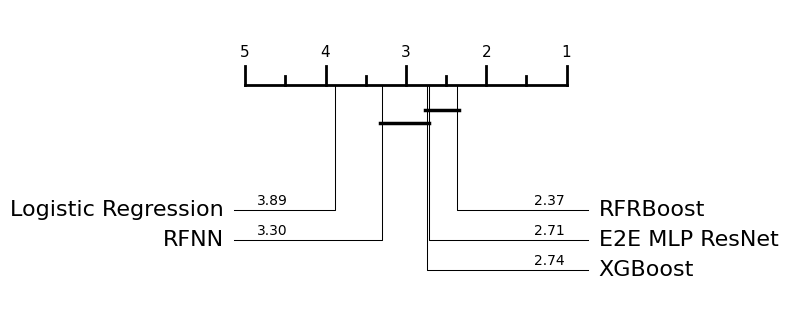

In [21]:
from aeon.visualisation import plot_critical_difference, plot_significance
import matplotlib.pyplot as plt

# Generate the plot
plot = plot_critical_difference(df_renamed["score_test"].values,
                                df_renamed["score_test"].columns.tolist(), 
                                alpha=0.10, 
                                lower_better=True,
                                digits=2,
                                width=7, #default 6
                                textspace=2.0, #default 1.5
                                return_p_values=True,
                                )

# Retrieve the figure and axes from the plot
fig = plot[0].figure
ax = plot[0]
print(plot[2])

# Adjust figure size
fig.set_size_inches(6, 3)

# Adjust layout
fig.tight_layout()

# Save the figures
plot[0].savefig("results/OpenMLClassification/OpenMLCls_critical_difference.eps", bbox_inches='tight')
plot[0].savefig("results/OpenMLClassification/OpenMLCls_critical_difference.png", bbox_inches='tight')

In [22]:
import pandas as pd
import numpy as np

def create_latex_table(
        df_scores: pd.DataFrame, 
        df_t_fit: pd.DataFrame, 
        decimals: int = 3, 
        include_std: bool = False) -> str:
    table = """\\begin{table}[t]
\\caption{Average test accuracies and fit times on the OpenML classification tasks.}
\\label{tab:openml-classification}
\\vskip 0.15in
\\begin{center}
\\begin{small}
\\begin{sc}
\\begin{tabular}{lcc}
\\toprule
Model & Acc & Fit Time (s) \\\\
\\midrule
"""
    # Calculate means and stds
    score_means = df_scores.mean()
    score_stds = df_scores.std()
    time_means = df_t_fit.mean()
    time_stds = df_t_fit.std()
    
    # Create sorted index based on scores
    sorted_idx = score_means.sort_values(ascending=False).index
    
    # Create formatted rows
    for model in sorted_idx:
        if include_std:
            score_str = f"{score_means[model]:.{decimals}f} ({score_stds[model]:.{decimals}f})"
            time_str = f"{time_means[model]:.{decimals}f} ({time_stds[model]:.{decimals}f})"
        else:
            score_str = f"{score_means[model]:.{decimals}f}"
            time_str = f"{time_means[model]:.{decimals}f}"
        table += f"{model} & {score_str} & {time_str} \\\\\n"
    
    table += """\\bottomrule
\\end{tabular}
\\end{sc}
\\end{small}
\\end{center}
\\vskip -0.1in
\\end{table}
"""
    return table


#usage
latex_table = create_latex_table(-df_renamed["score_test"], df_renamed["t_fit"])
print(latex_table)

\begin{table}[t]
\caption{Average test accuracies and fit times on the OpenML classification tasks.}
\label{tab:openml-classification}
\vskip 0.15in
\begin{center}
\begin{small}
\begin{sc}
\begin{tabular}{lcc}
\toprule
Model & Acc & Fit Time (s) \\
\midrule
XGBoost & 0.852 & 3.695 \\
RFRBoost & 0.851 & 3.032 \\
E2E MLP ResNet & 0.850 & 30.518 \\
RFNN & 0.844 & 2.048 \\
Logistic Regression & 0.821 & 0.187 \\
\bottomrule
\end{tabular}
\end{sc}
\end{small}
\end{center}
\vskip -0.1in
\end{table}



# Look at distribution of params

Model: End2End_cpu
in_dim


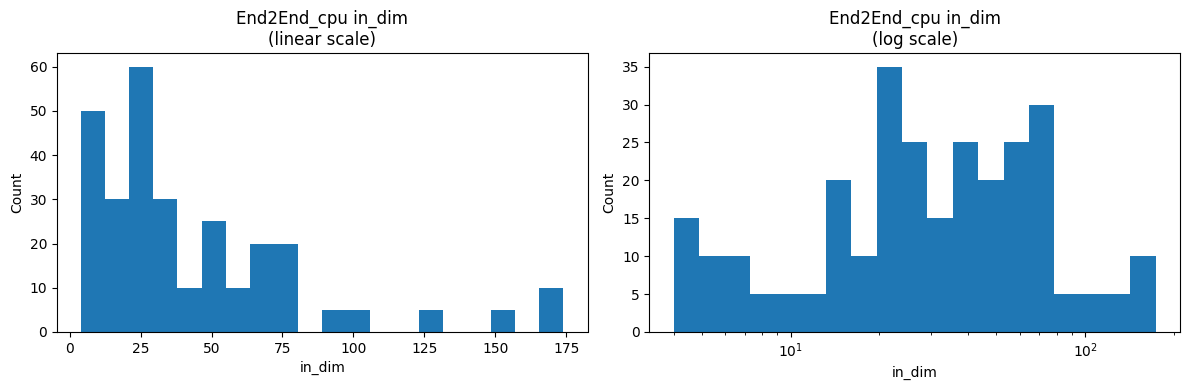

bottleneck_dim


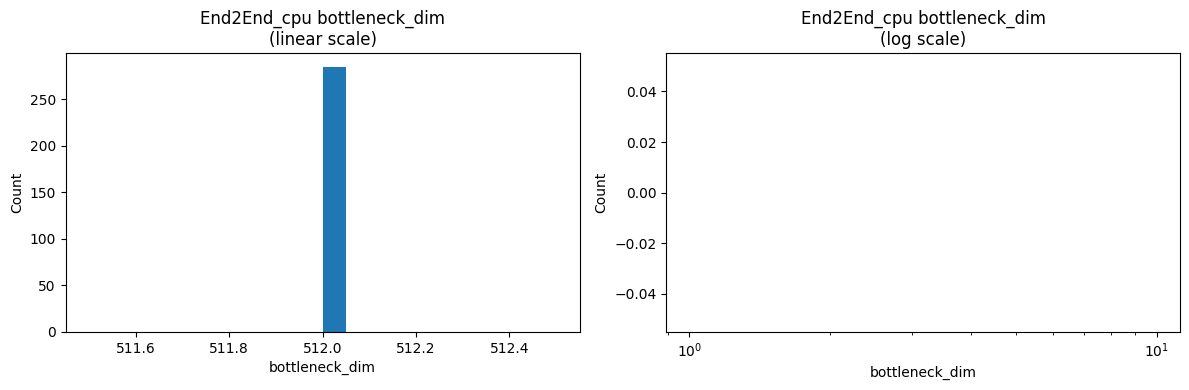

n_blocks


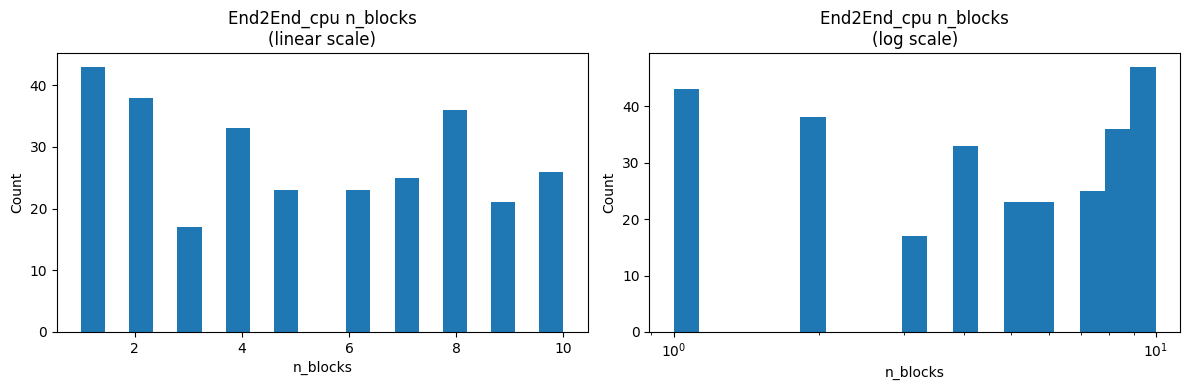

hidden_dim


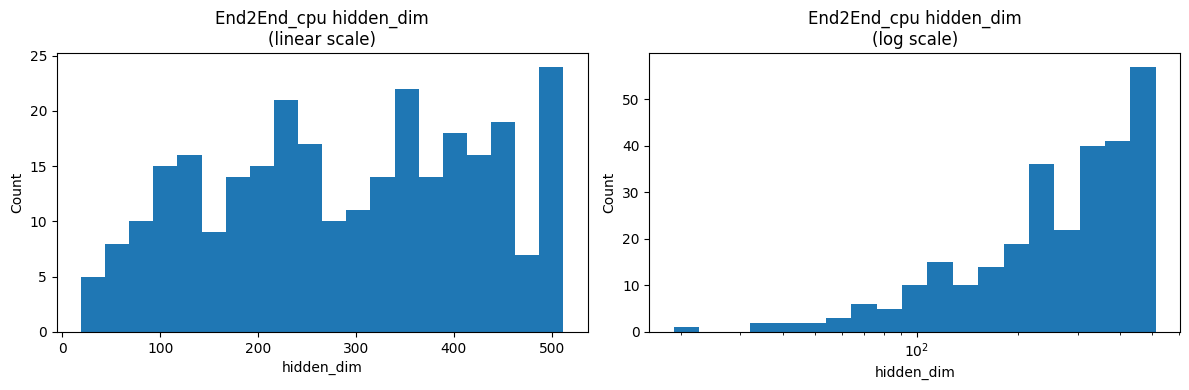

lr


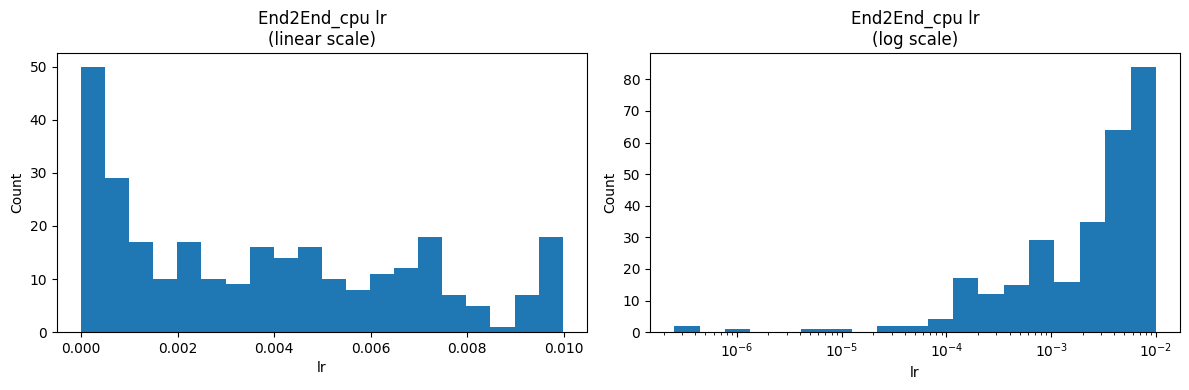

end_lr_factor


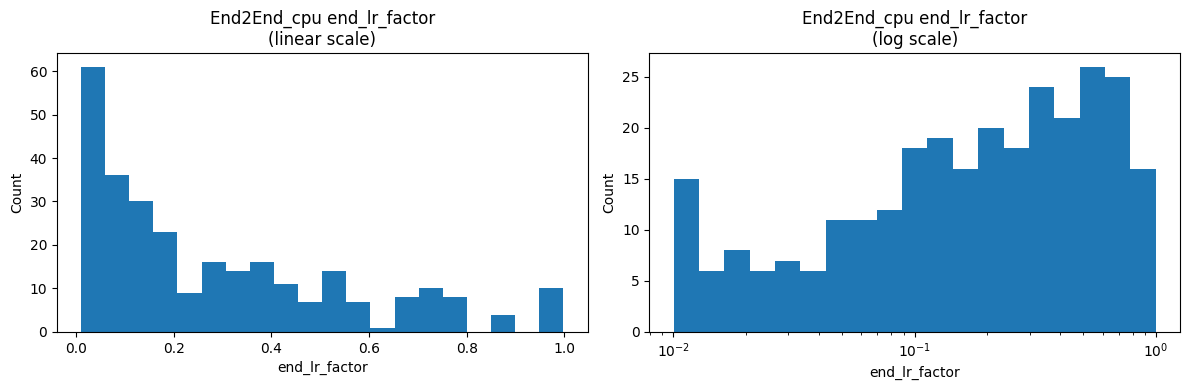

n_epochs


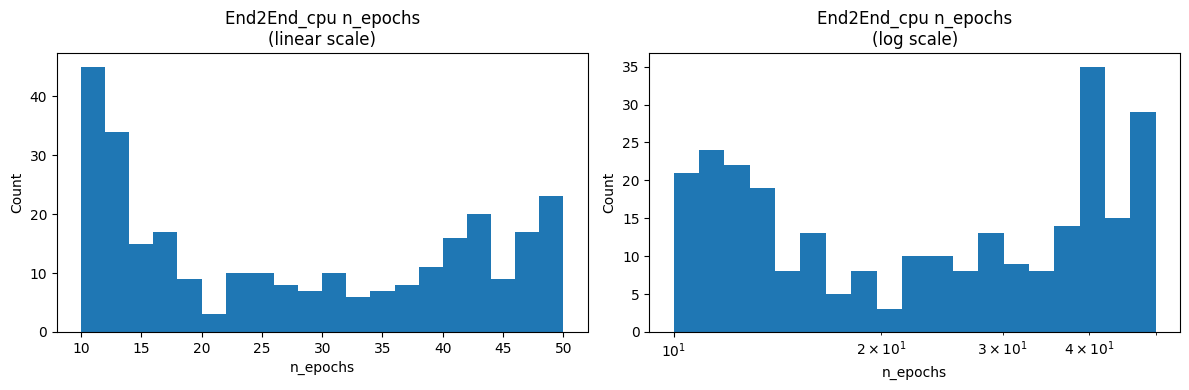

weight_decay


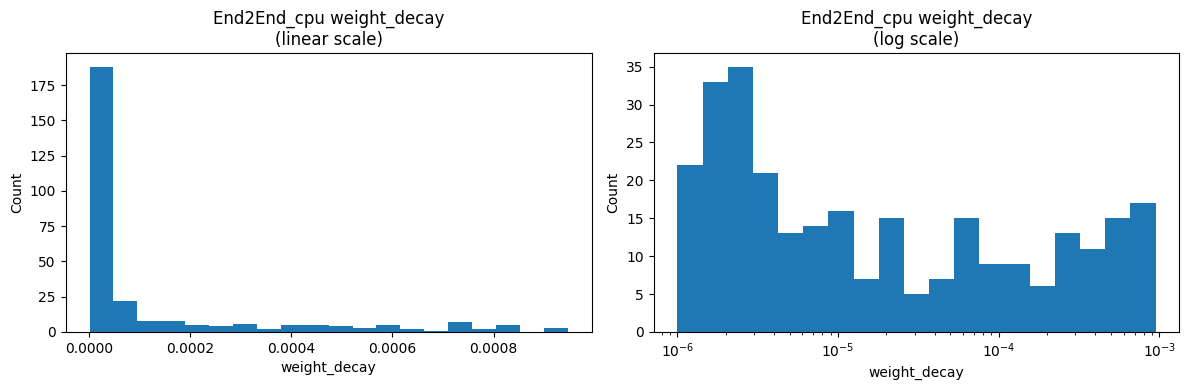

batch_size


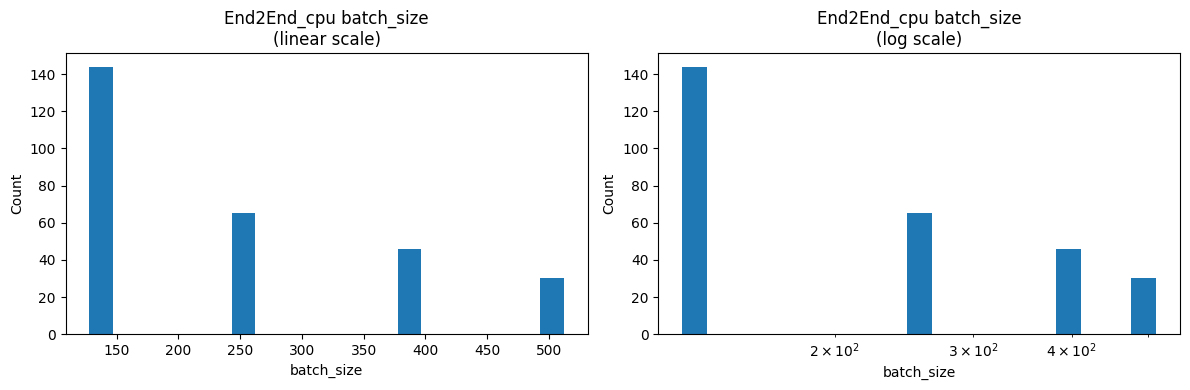

Model: LogisticRegression
l2_lambda


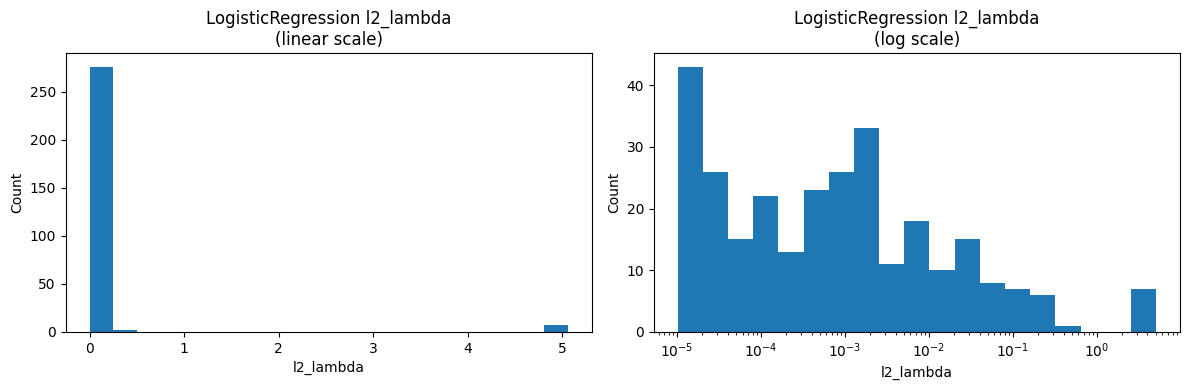

Model: RFNN
n_layers


/tmp/ipykernel_79046/3106444037.py:53: RuntimeWarning: divide by zero encountered in log10
  bins = np.logspace(np.log10(min_val), np.log10(max_val), 20)


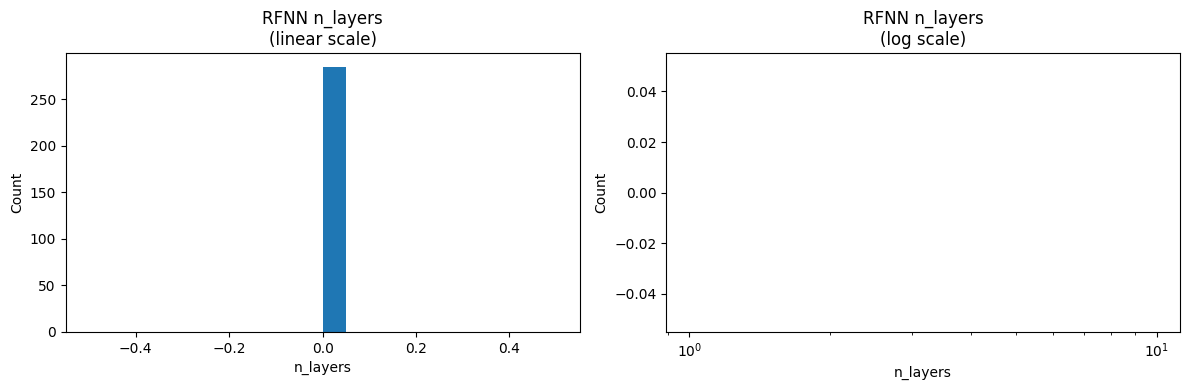

in_dim


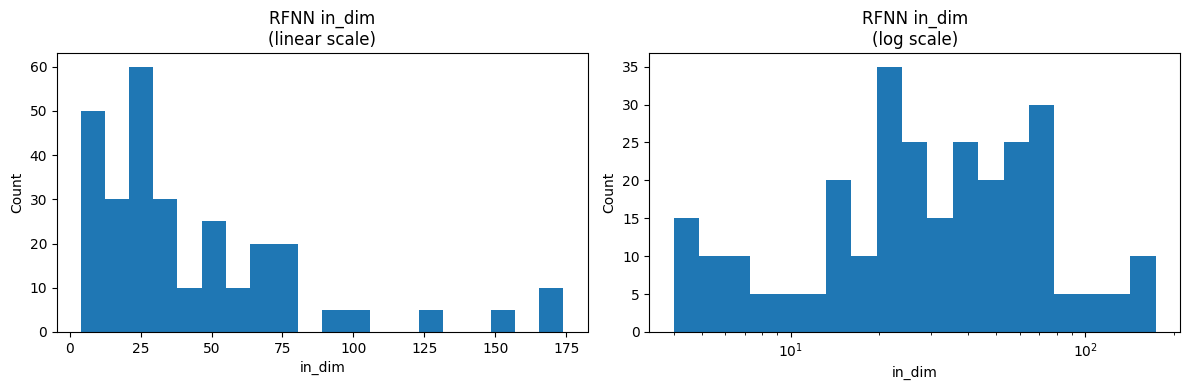

hidden_dim


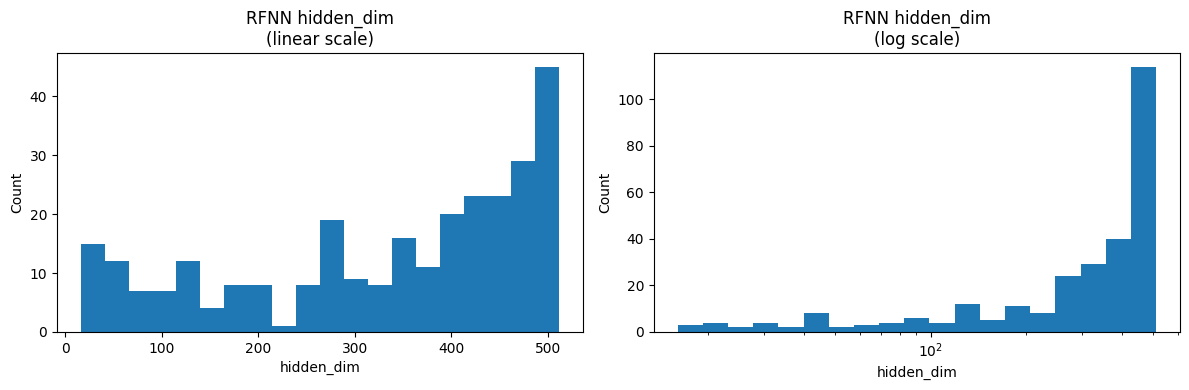

SWIM_scale


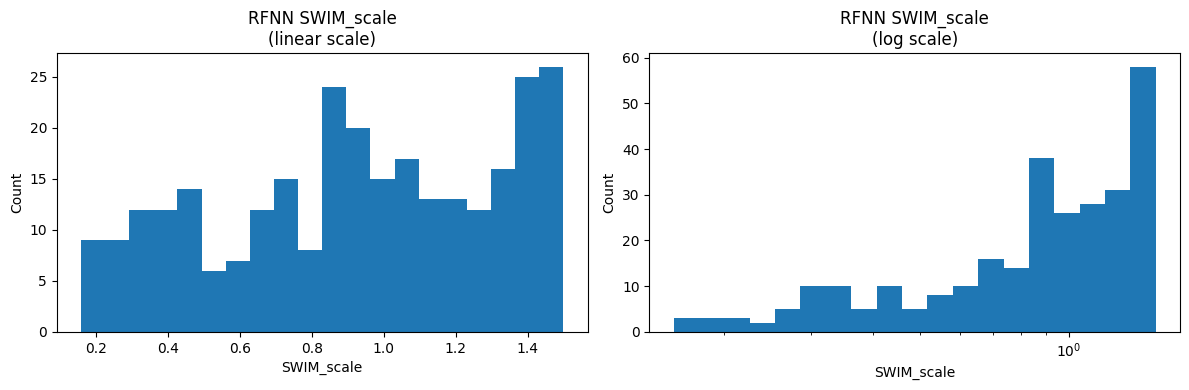

l2_cls


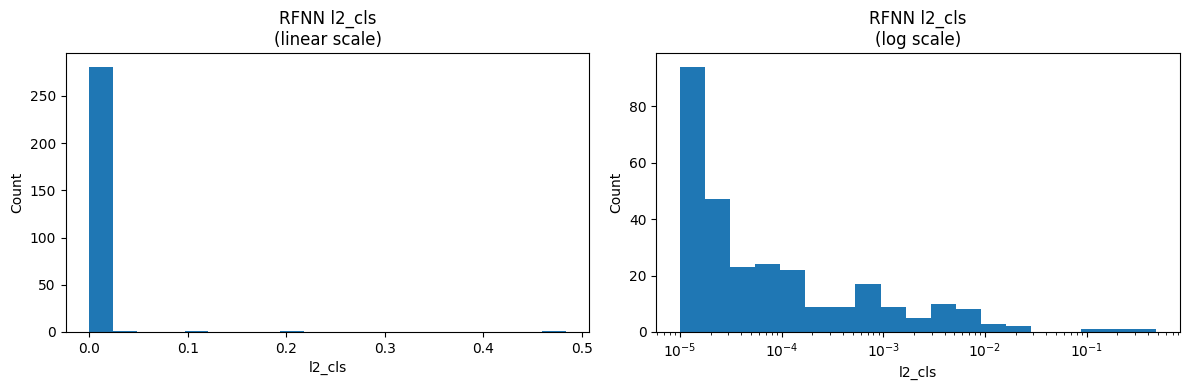

Model: RFRBoost_ID_batchnormFalse
in_dim


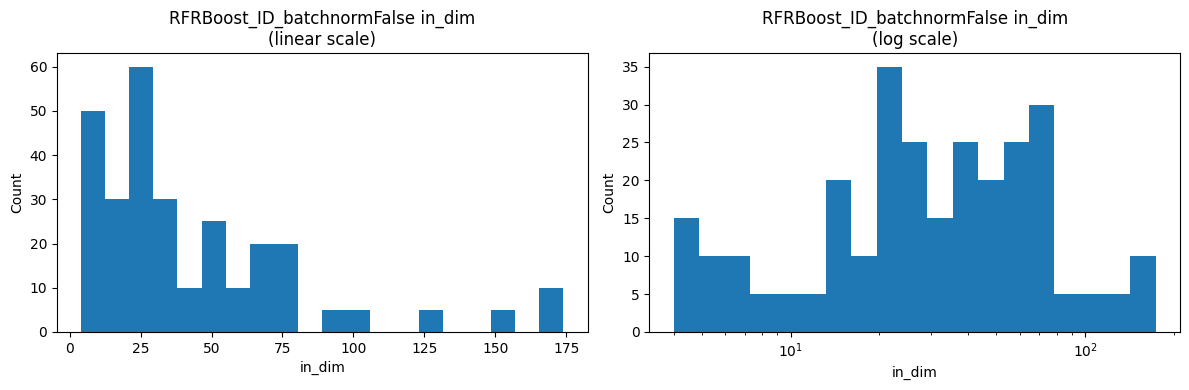

randfeat_xt_dim


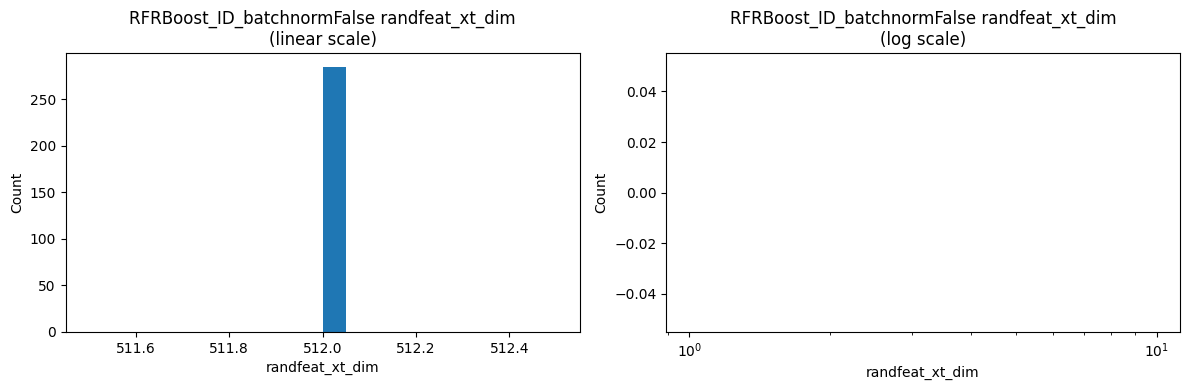

randfeat_x0_dim


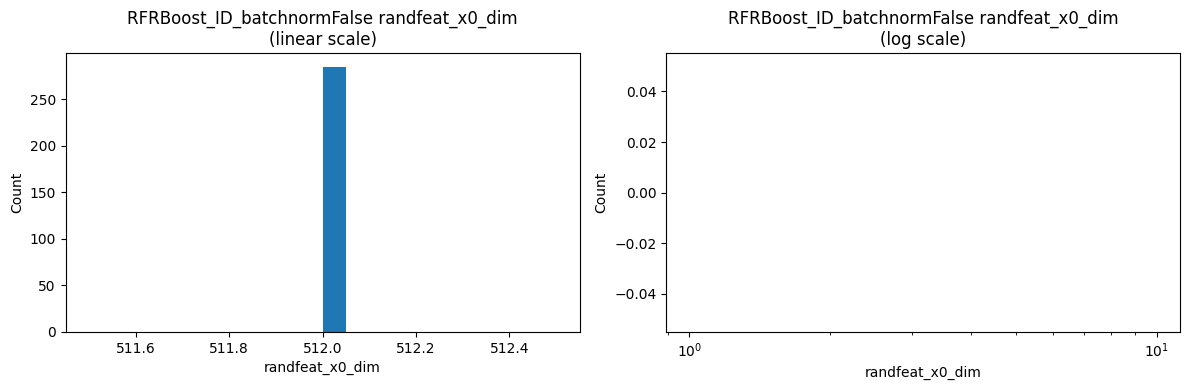

n_layers


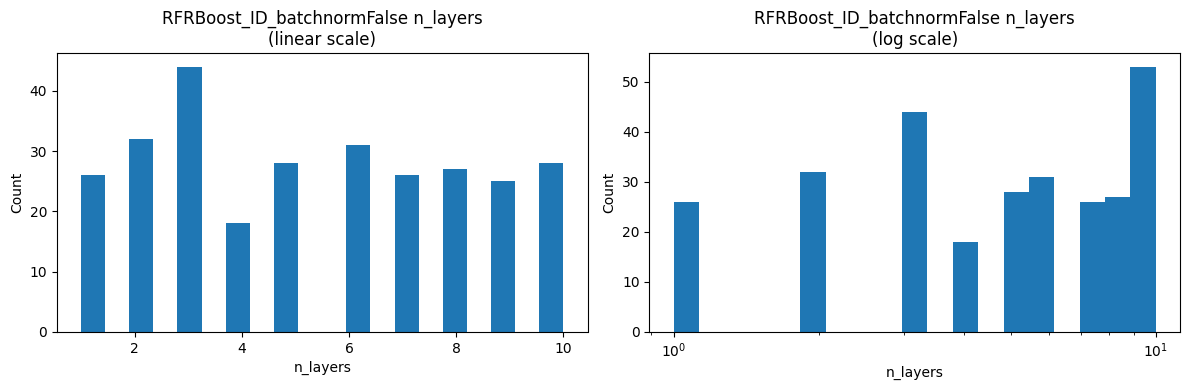

hidden_dim


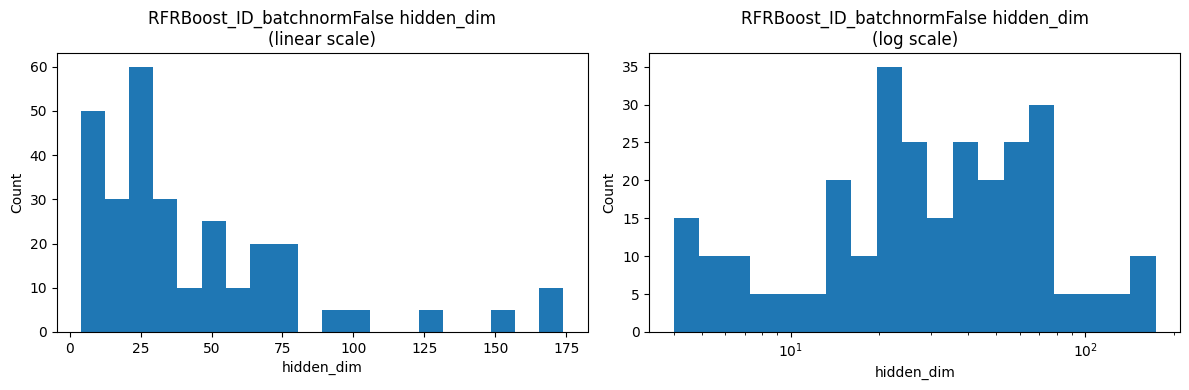

l2_cls


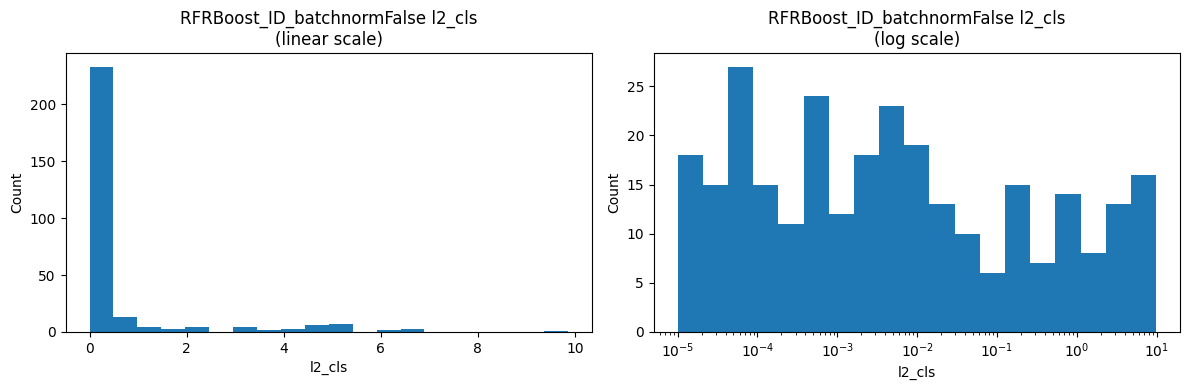

l2_ghat


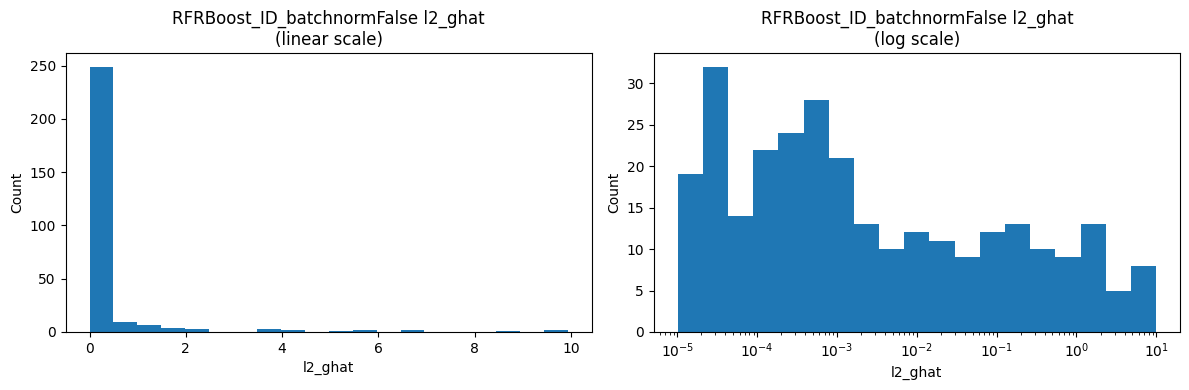

boost_lr


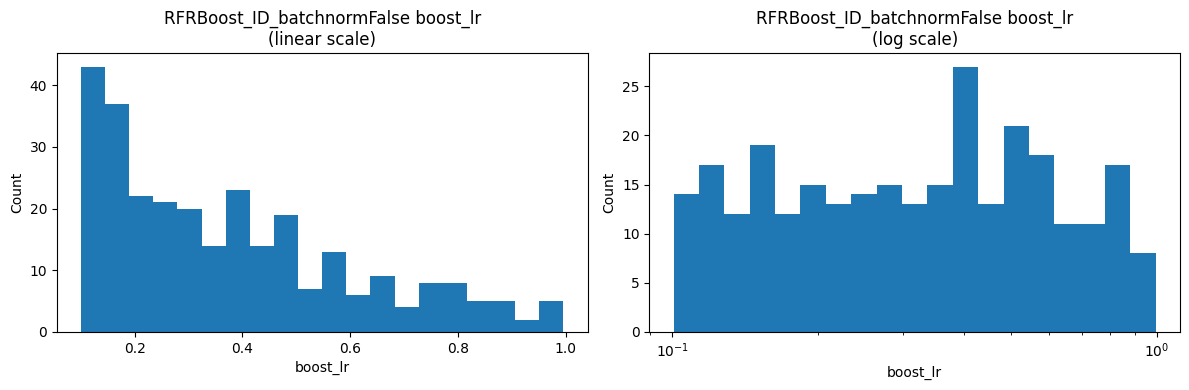

SWIM_scale


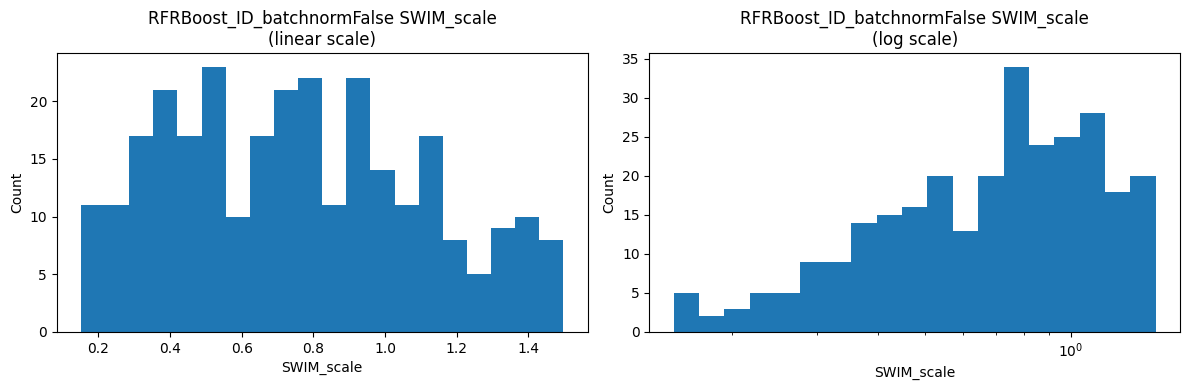

In [24]:
import matplotlib.pyplot as plt

def plot_param_distribution(
        models = ["End2End_cpu", 
                    "LogisticRegression", #"XGBoostClassifier", 
                    "RFNN", #"RFNN_iid", 
                    "RFRBoost_ID_batchnormFalse",
                    #"RFRBoost_upscaleiid_batchnormFalse",
                    ],
        datasets = openML_cls_ids[[i for i in range(len(openML_cls_ids)) if i not in []]],
        save_dir = "/home/nikita/Code/random-feature-boosting/save/OpenMLClassification/",
        ):
    # Load and join the JSON data
    results_json = get_joined_results_json(models, datasets, save_dir)

    # model: list_of_param_names
    modelwise_param_names = {model: list(results_json[str(datasets[0])][model]['hyperparams'][0])
                            for model in models} 

    # model: param_name: list_of_param_values
    param_distribution = { model: {param: [] for param in param_names}
                          for model, param_names in modelwise_param_names.items()}

    #populate teh param_districution nested dict
    for dataset, dataset_results in results_json.items():
        for model_name, model_results in dataset_results.items():
            for fold in model_results["hyperparams"]:
                for param_name, param_val in fold.items():
                    param_distribution[model_name][param_name].append(param_val)

    # For each model, plot the distribution of each parameter
    for model, param_dict in param_distribution.items():
        print(f"Model: {model}")
        for param_name, param_values in param_dict.items():
            if param_name not in [
                "out_dim", "loss", "objective", "feature_type",
                "upscale_type", "sandwich_solver", "n_classes", "activation",
                "use_batchnorm", "do_linesearch",
                ]:
                print(param_name)
                # Create figure with two subplots side by side
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
                
                # Linear scale plot
                ax1.hist(param_values, bins=20)
                ax1.set_title(f"{model} {param_name}\n(linear scale)")
                ax1.set_xlabel(param_name)
                ax1.set_ylabel("Count")
                
                # Log scale plot
                min_val = np.min(param_values)  # Avoid log(0)
                max_val = np.max(param_values)
                bins = np.logspace(np.log10(min_val), np.log10(max_val), 20)
                ax2.hist(param_values, bins=bins)
                ax2.set_xscale('log')
                ax2.set_title(f"{model} {param_name}\n(log scale)")
                ax2.set_xlabel(param_name)
                ax2.set_ylabel("Count")
                
                plt.tight_layout()
                plt.show()

plot_param_distribution()